# Feature Selection

### Feature Selection
<img src="../imgs/03.3.02_1.png" align="right"  width=600><br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li> Purpose </li>

<li> Types of feature filtering
<ul>
<li>Linear Correlation</li>
<li>Phik Correlation</li>
<li>Feature importance</li>
<li>Permutation importance</li>
<li>SHAP values</li>
<li>CatBoost feature selection </li>    
<li>Boruta</li>
<li>BoostARoota</li>
    
</ul>
</li>
    
<li>Review features
<li>Conclusion

</li></ul></font></p>

### Purpose

<div class="alert alert-info">

As we can see in the lessons about **Feature engineering** and automatic feature generation, we can quickly generate a large number of features, especially in automatic mode. Why then throw out some of them? <br> 
There are several main reasons:
* The first one, which lies on the surface, is that if there are a lot of features, then the data may no longer fit in memory; the training time of the model may significantly increase, especially if we want to test several different algorithms or an ensemble. Especially when platforms are limited to the duration of a single session (12 hours in Kaggle) and memory consumption limits.
* But the main reason is that as the number of features increases, the accuracy of model prediction often decreases. Especially if there are a lot of junk features in the data (almost not correlating with the target). Some algorithms, with a strong increase in the number of features, generally cease to work adequately. In other words, what we get as a result is **overfitting**
* Even if the accuracy does not decrease, there is a risk that your model relies on noisy features, which will reduce the stability of the forecast for a private sample.

## 1. Feature Selection Methods
There are 3 main Feature Selection methods:
* Filter methods
* Wrapper methods
* Embedded methods

<div class="alert alert-info">    
    
## **1.1 - Filter methods**

These methods are based on statistical methods and, as a rule, consider each feature independently. They allow you to evaluate and rank features according to their significance, which is taken as the degree of correlation of this feature with the target variable. The main advantage of this group of methods is the low cost of calculations, which linearly depends on the total number of features.  They are significantly faster than both wrapper and embedded methods. In addition, they work well even when the number of features exceeds the number of examples in the training sample (which is not always possible for methods of other categories). <br>
The main disadvantage of these methods is that they consider each feature in isolation from the others, so they are not as accurate, but they can quickly sort out the features. However, progress does not stand still and filter methods are emerging that try to solve this problem in different ways - based on mutual information of features, or taking into account the redundancy of features 
(the mRmR method is minimal redundancy with maximum relevance). <br>
Some of these methods are implemented in the `sklearn.feature_selection` section of the scikit-learn library, for example, `SelectKBest`, `chi2`, etc. Similarly, **feature importance** in gradient boosting libraries can be said to be based on this technique, but to the same extent they can be attributed to embedded methods is a debatable issue.

<div class="alert alert-info">    

## **1.2 - Embedded methods**

Where are they embedded? Right into the learning process of the model. These models make it possible not to separate the processes of training and feature selection, i.e., during model training, we filter out and get a model at the output that knows which features to pay more attention to and which are garbage. These methods require less calculations than wrapper methods, but more than filtering methods. As you probably already guessed, the main methods from this group are our "old friends" - regularization (for example, LASSO and Ridge regressions), DecisionTree and randomForest algorithms, there are also regularizations in boosters and neural networks.<br>
Regularization also has disadvantages: at least once you will have to train the model on all the signs and look at the coefficients, which is not always convenient and feasible. Similarly, a model trained on all signs will work slower with inference. But in general, this method is better able to capture the interdependencies of variables than filtering methods.

<div class="alert alert-info">    

## **1.3 - Wrapper methods**
What do they wrap? And they wrap the training of the model in sequential removal (backward feature selection) or addition (forward fs) of features. Backward feature selection is better at tracking the relationships between features, but it is much more computationally expensive.<br>
The main disadvantage of all wrapper methods is the long calculation time. In addition, in the case of a large number of features and a small size of the training dataset, these methods are in danger of overfitting.<br>
Some examples of such methods: RFE (recursive feature elimination) from **scikit-learn** package, **Boruta** of **BorutaPy** (for **RandomForest** algorithm), etc.<br>

<div class="alert alert-info">    

Sometimes it is difficult to determine unequivocally which group a particular method belongs to, or whether it is a hybrid that combines several methods. For example, when using the **CatBoost** gradient boosting library, you can touch all 3 types of methods or a combination of them: if you just take feature importance with default parameters and disabled regularization, we get the filter method; if we add parameters responsible for regularization to the model, we get a kind of hybrid - like the filter method, but at the same time with regularization (embedded method); if we use the `feature_selection()` function built into CatBoost, the wrapper method with backward fs will work.

# Practice

In [10]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", "{:,.2f}".format)
from classes import Paths

In [11]:
paths = Paths()
path = paths.quickstart_train

df = pd.read_csv(path)
df.head(10)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.74,"12,141,310.41",0.10,180.86,0.02,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.48,"18,039,092.84",0.00,187.86,12.31,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.77,"15,883,659.43",0.10,102.38,2.51,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.88,"16,518,828.77",0.10,172.79,-5.03,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.18,"13,983,174.66",0.10,203.46,-14.26,174,171
5,b12101843B,Skoda Rapid,economy,petrol,2.36,2013,42176,2018,48.99,engine_ignition,4.35,"10,855,890.99",0.10,180.89,-18.22,174,173
6,Q-9368117S,Nissan Qashqai,standart,petrol,5.32,2012,24611,2014,54.72,engine_overheat,4.39,"8,343,280.33",0.10,174.98,12.32,174,167
7,O-2124190y,Tesla Model 3,premium,electro,3.90,2017,116872,2019,50.40,gear_stick,4.71,"9,793,288.03",0.10,95.89,-8.94,174,139
8,h16895544p,Kia Sportage,standart,petrol,3.50,2014,56384,2017,33.59,gear_stick,4.51,"16,444,046.89",0.32,101.80,-1.16,174,170
9,K77009462l,Smart ForFour,economy,petrol,4.56,2013,41309,2018,39.04,gear_stick,4.38,"6,975,742.48",0.10,125.25,3.77,174,173


# What we can delete immediately?

<div class="alert alert-info">
    
* Constants
* Unique values (including in the test, usually these are IDs like `car_id`)

In [12]:
df.loc[:, ["deviation_normal_count"]].value_counts()

deviation_normal_count
174                       2337
Name: count, dtype: int64

# Let's add some random features into dataset

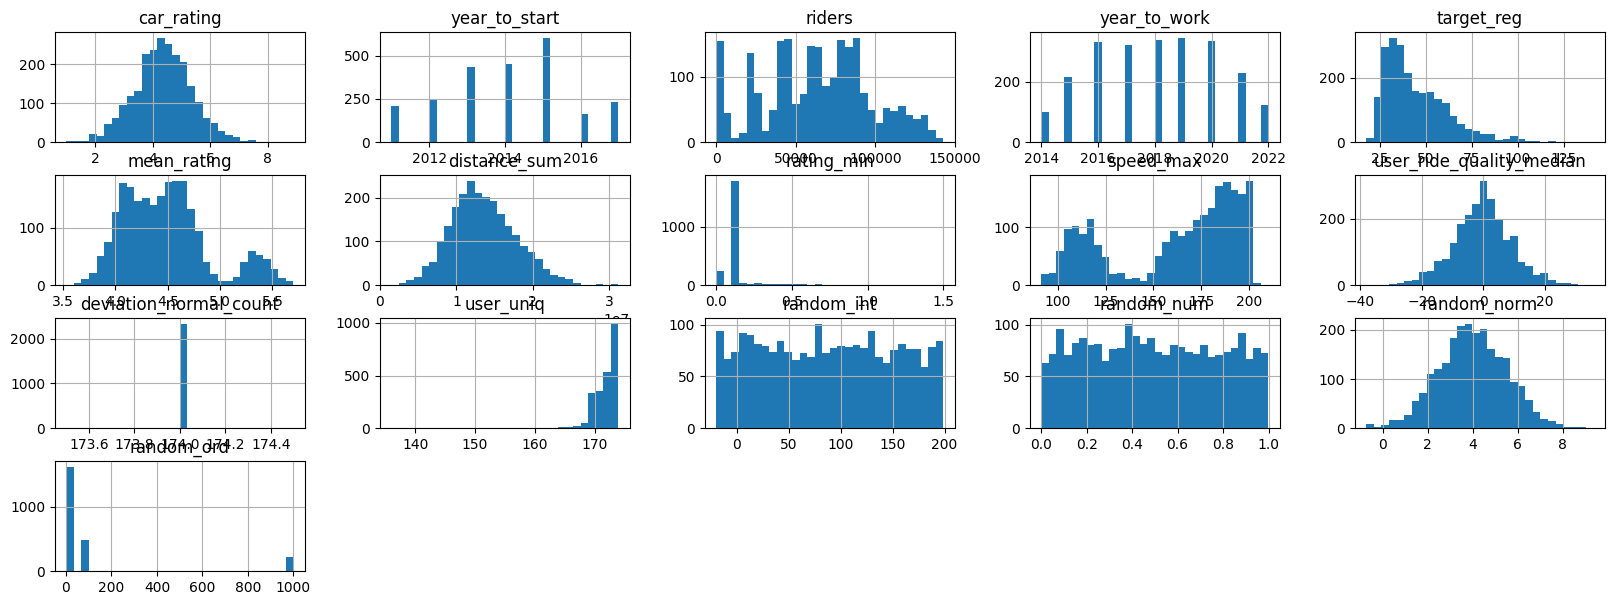

In [13]:
df['random_int'] = np.random.randint(-20, 200, df.shape[0]) # random Whole Numbers Feature
df['random_num'] = np.random.random(size = df.shape[0]) # float type feature with uniform distribution
df['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = df.shape[0]) # normally distributed feature
df['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = df.shape[0]) # imbalanced str categorical feature
df['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = df.shape[0]) # Numeric Categorical Feature

df.hist(figsize = (20, 7), layout = (-1, 5), bins=30);

# Linear Correlation

<Axes: >

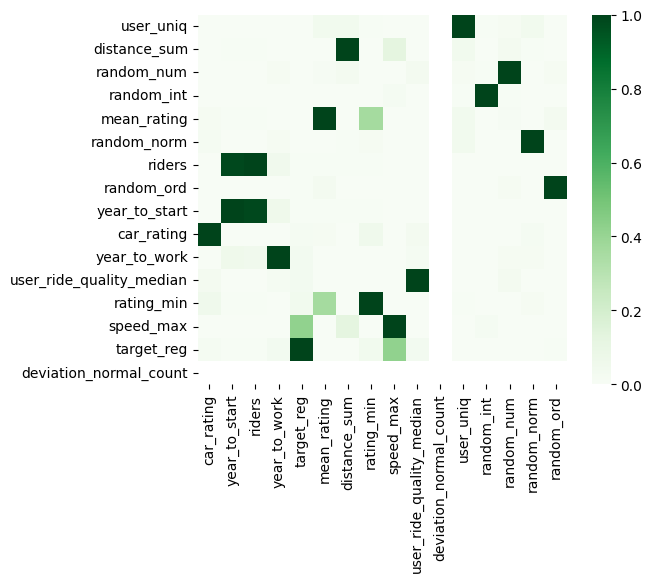

In [14]:
corrs = df.dropna().corr(numeric_only=True).round(3).sort_values(by=['target_reg'])
sns.heatmap(
    corrs
    , cmap='Greens'
    , square=True
    , vmin=-0
)

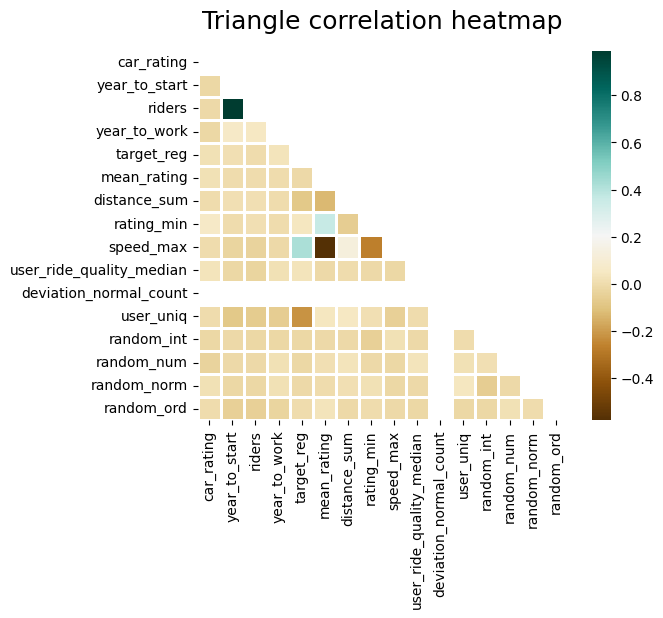

In [15]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
# display(np.ones_like(df.corr(numeric_only=True), dtype=bool)[:3]) # all trues
# display(mask[:3])                                                 # triu - upper trues, tril - lower trues

heatmap = sns.heatmap(
    df.corr(numeric_only=True).round(2),

    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.1},
    linewidth=1,
    
    mask=mask,
)

heatmap.set_title(
    "Triangle correlation heatmap", fontdict={"fontsize": 18}, pad=16
);


<div class="alert alert-success">

**Advantages and disadvantages of correlation filtering?**

* ✅ Fast and clear
* ❌ Does not capture nonlinear dependencies
* ❌ Omits paired dependencies
* ❌ Is not suitable for categories (another stat criterion is needed)

# Phik correlation

* [Documentation](https://pypi.org/project/phik/)
* [Tutorial](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)

In [16]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'random_int', 'random_num', 'random_norm', 'random_ord']


/Users/lecha/dev/comp-ds/.venv/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable deviation_normal_count for analysis 1. Dropping this column
  warnings.warn(


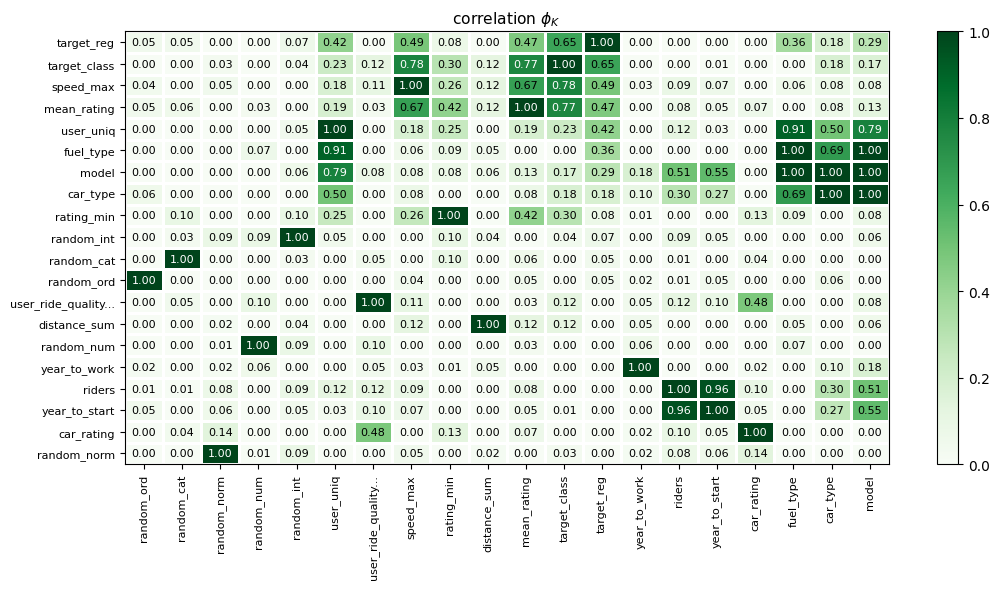

In [17]:
phik_overview = df.drop(columns=['car_id']).phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'random_int', 'random_num', 'random_norm', 'random_ord']


/Users/lecha/dev/comp-ds/.venv/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable deviation_normal_count for analysis 1. Dropping this column
  warnings.warn(


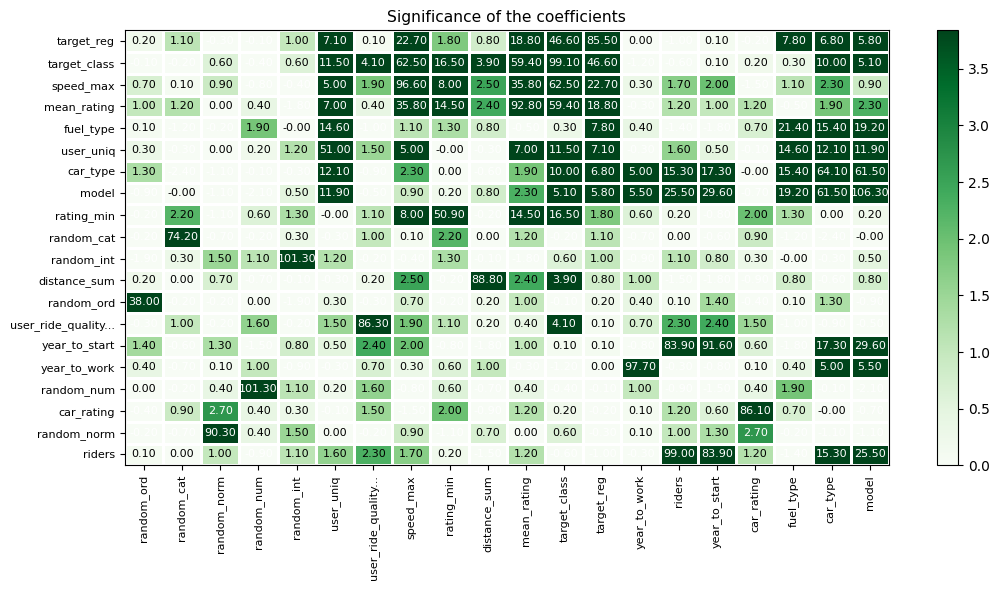

In [18]:
significance_overview = df.drop(columns=['car_id']).significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=3.84, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

<div class="alert alert-success">

**Interpretation of logarithmic probability**

<div class="alert alert-info">

If the logarithmic probability of your result is `greater than 6.63`, the probability that the result will happen by chance is less than 1%. Thus, we can be `99% sure` that the result really means something. In terms of p-value, this is usually expressed as 
- `p < 0.01`.  

If the logarithmic probability `is 3.84 or more`, the probability that this will happen by chance is less than 5%. So we are `95% sure` of the result. In terms of p-value this is expressed as 
- `p < 0.05`.

<div class="alert alert-success">

**Advantages and disadvantages of the `phik` method?**

* ✅ Works with categorical values
* ✅ Finds nonlinear dependencies
* ❌ Does not find paired dependencies
* ❌ Counts for a long time if number of features is too big

# Feature Importance

In [19]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [20]:
drop_cols = ['car_id', 'target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model', 'random_cat']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.8563281	test: 1.8673519	best: 1.8673519 (0)	total: 75ms	remaining: 1m 14s
100:	learn: 0.4009671	test: 0.5639727	best: 0.5639727 (100)	total: 1.64s	remaining: 14.6s
200:	learn: 0.2765598	test: 0.5609788	best: 0.5574345 (138)	total: 3.21s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5574345355
bestIteration = 138

Shrink model to first 139 iterations.


In [23]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,37.23
1,mean_rating,32.71
2,rating_min,14.25
3,user_uniq,2.48
4,car_type,2.47
5,model,2.46
6,random_cat,1.75
7,user_ride_quality_median,1.03
8,random_norm,0.94
9,car_rating,0.80


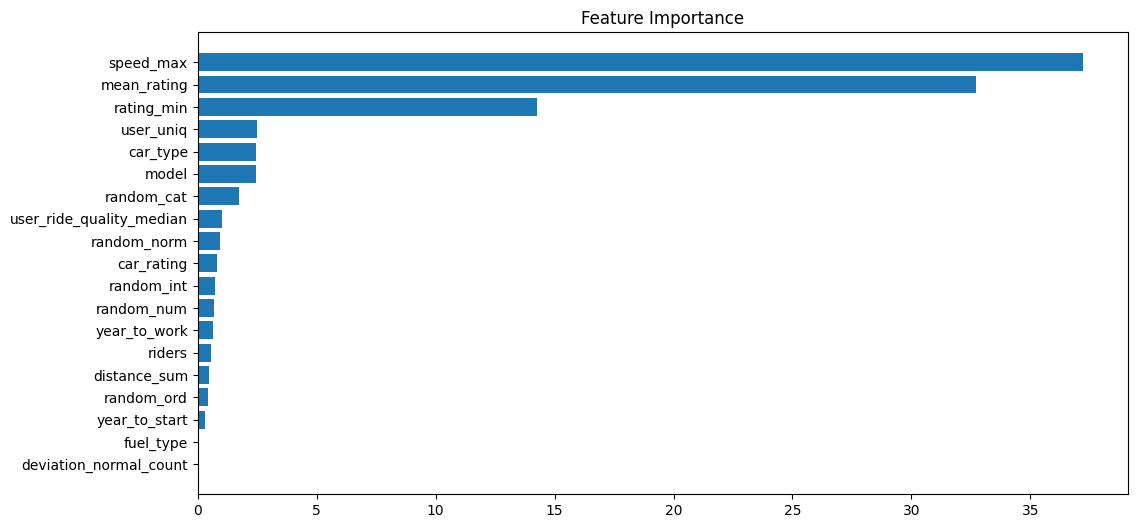

In [24]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');